In [1]:
import os
import sys
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy import spatial
from scipy import stats
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

import read_data, concatenation, radar

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
invalid = [10139, 10589, 10615, 10150, 10151]

# Gage - Radar

In [4]:
overwrite = 0

if (os.path.exists('../data/gage_radar.csv')) and (not overwrite):
    gage_radar = pd.read_csv('../data/gage_radar.csv').set_index(['time', 'gage_name'])
else:
    dates = ['20140811', '20140628', '20140612'] 

    wu_0 = pd.DataFrame()
    wu_1 = pd.DataFrame()

    for date in dates:

        radar_panel = read_data.radar_to_panel('../data/DTX_DPR_{0}.nc'.format(date))

        wu_df, wu_locs = read_data.read_wu_gages()
        wu_df.drop('KMIYPSIL10', axis=1, inplace=True)
        wu_day = wu_df.loc[date].dropna(axis=1, how='all')
        r, c = np.where(~np.isnan(wu_day.values))
        t = wu_day.index[r]
        xy = wu_locs.loc[wu_day.columns[c], ['lon', 'lat']].values 

        i_t, i_y, i_x = concatenation.panel_spacetime_index(radar_panel, t, xy)

        wu_out = np.repeat(np.nan, wu_day.size).reshape(wu_day.shape)
        wu_out[r, c] = radar_panel.values[i_t, i_y, i_x]
        wu_out = pd.DataFrame(wu_out, index=wu_day.index, columns=wu_day.columns)
        wu_0 = wu_0.append(wu_day)
        wu_1 = wu_1.append(wu_out)

    gage_radar = pd.concat([wu_0.stack(), wu_1.stack()], axis=1)
    gage_radar.columns = ['Gage', 'Radar']
    gage_radar.index.names = ['time', 'gage_name']
    gage_radar.to_csv('../data/gage_radar.csv')

# Radar - Vehicle

In [5]:
overwrite = 0

if (os.path.exists('../data/veh_radar.csv')) and (not overwrite):
    gage_radar = pd.read_csv('../data/veh_radar.csv')
else:
    dates = ['20140811', '20140628', '20140612'] 

    veh_radar = pd.DataFrame(columns=['Wiper', 'Radar'])

    for date in dates:

        radar_panel = read_data.radar_to_panel('../data/DTX_DPR_{0}.nc'.format(date))

        veh = read_data.read_vehicle_data('../data/{0}.csv'.format(date))

        # Correct vehicle data
        ymin = radar_panel.major_axis.min()
        ymax = radar_panel.major_axis.max()
        xmin = radar_panel.minor_axis.min()
        xmax = radar_panel.minor_axis.max()
        veh = veh[(veh['Latitude'] > ymin) & (veh['Latitude'] < ymax) &
                  (veh['Longitude'] > xmin) & (veh['Longitude'] < xmax)]
        veh = veh[veh['GPS_Speed'] > 1]
        veh = veh[~veh['Device'].isin(invalid)]

        t = veh.index
        xy = veh[['Longitude', 'Latitude']].values
        i_t, i_y, i_x = concatenation.panel_spacetime_index(radar_panel, t, xy)
        veh['Radar'] = radar_panel.values[i_t, i_y, i_x]
        veh_radar = veh_radar.append(veh[['Wiper', 'Radar']])
        veh_radar.to_csv('../data/veh_radar.csv')

# Gage - Vehicle

In [7]:
overwrite = 0
max_dist = 2

if (os.path.exists('../data/veh_gage_{0}km.csv'.format(max_dist))) and (not overwrite):
    veh_gage = pd.read_csv('../data/veh_gage_{0}km.csv'.format(max_dist))
else:
    dates = ['20140811', '20140628', '20140612']
    wu_df, wu_locs = read_data.read_wu_gages()
    wu_df.drop('KMIYPSIL10', axis=1, inplace=True)

    veh_gage = []

    for date in dates:
        wu_day = wu_df.loc[date]
        gages = wu_df.columns[wu_df.loc[date].any()]
        veh = read_data.read_vehicle_data('../data/{0}.csv'.format(date))
        
        veh = veh[veh['GPS_Speed'] > 1]
        veh = veh[~veh['Device'].isin(invalid)]
        
        for gage in gages:
            df = concatenation.join_gage_to_vehicle(wu_df[gage].dropna(),
                                      wu_locs.loc[gage, ['lon', 'lat']],
                                      veh)
            df = df.query('Dist_km < {0}'.format(max_dist))[['Wiper', gage]].values
            veh_gage.append(df)
    veh_gage = pd.DataFrame(np.vstack(veh_gage), columns=['Wiper', 'Gage'])
    veh_gage.to_csv('../data/veh_gage_{0}km.csv'.format(max_dist))

In [8]:
gage_radar = pd.read_csv('../data/gage_radar.csv')
veh_radar = pd.read_csv('../data/veh_radar.csv')
veh_gage = pd.read_csv('../data/veh_gage_2km.csv')

In [9]:
veh_radar['Wiper'] = veh_radar['Wiper'].astype(int)
veh_gage['Wiper'] = veh_gage['Wiper'].astype(int)
veh_radar_log = veh_radar.copy()
veh_gage_log = veh_gage.copy()

In [10]:
veh_radar['Radar'][veh_radar['Radar'].isnull()] = 0

In [11]:
intomm = 25.4
veh_radar['Radar'] *= intomm
veh_gage['Gage'] *= intomm

In [12]:
radar_means = [veh_radar['Radar'][veh_radar['Wiper'] == i].mean() for i in range(4)]
gage_means = [veh_gage['Gage'][veh_gage['Wiper'] == i].mean() for i in range(4)]
radar_meds = [veh_radar['Radar'][veh_radar['Wiper'] == i].median() for i in range(4)]
gage_meds = [veh_gage['Gage'][veh_gage['Wiper'] == i].median() for i in range(4)]

# Generate plots

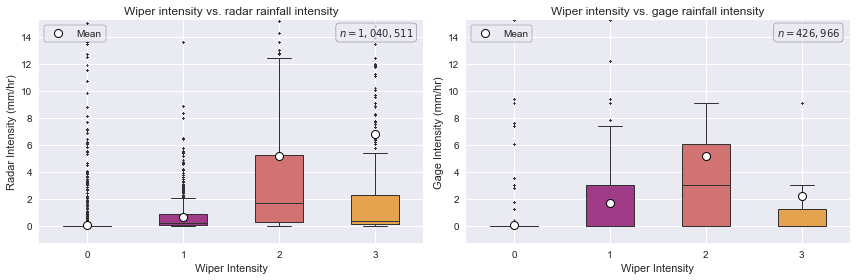

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(x='Wiper', y='Radar', data=veh_radar, ax=ax[0], palette='plasma',
            linewidth=1, fliersize=2, width=0.5)
sns.boxplot(x='Wiper', y='Gage', data=veh_gage, ax=ax[1], palette='plasma',
            linewidth=1, fliersize=2, width=0.5)

ax[0].plot(range(4), radar_means, linewidth=0,
             color='w', marker='o', markeredgecolor='k', markersize=8, markeredgewidth=1, zorder=5, label='Mean')
ax[1].plot(range(4), gage_means, linewidth=0,
             color='w', marker='o', markeredgecolor='k', markersize=8, markeredgewidth=1, zorder=5, label='Mean')

ax[0].set_ylim(-0.05*intomm, 0.6*intomm)
ax[1].set_ylim(-0.05*intomm, 0.6*intomm)

leg0 = ax[0].legend(frameon=True, loc=2)
leg1 = ax[1].legend(frameon=True, loc=2)
leg0.get_frame().set_edgecolor('0.1')
leg1.get_frame().set_edgecolor('0.1')

ax[0].set_xlabel('')
ax[0].set_ylabel('Radar Intensity (mm/hr)')
ax[0].set_xlabel('Wiper Intensity')
ax[1].set_xlabel('Wiper Intensity')
ax[1].set_ylabel('Gage Intensity (mm/hr)')
ax[0].set_title('')
ax[1].set_title('')
ax[0].grid('on')
ax[1].grid('on')

textstr0 = r'$n = {:,}$'.format(veh_radar.shape[0])
textstr1 = r'$n = {:,}$'.format(veh_gage.shape[0])
props = dict(boxstyle='round', facecolor=leg0.properties()['frame'].properties()['facecolor'],
             alpha=leg0.properties()['frame'].properties()['alpha'])
ax[0].text(0.975, 0.975, textstr0, transform=ax[0].transAxes,
        verticalalignment='top', horizontalalignment='right', bbox=props)
ax[1].text(0.975, 0.975, textstr1, horizontalalignment='right', transform=ax[1].transAxes,
        verticalalignment='top', bbox=props)

ax[0].set_title('Wiper intensity vs. radar rainfall intensity')
ax[1].set_title('Wiper intensity vs. gage rainfall intensity')

plt.tight_layout()
plt.savefig('../img/fig4.pdf', bbox_inches='tight')